# Solve the 1D Linear Schrödinger equation using a Physics Informed Neural Network

In the following, we will solve the dimensionless 1D Schrödinger equation with inhomogeneous Dirichlet boundary conditions using a Physics Informed Neural Network (PINN).
This boundary values problem can be stated as

$$ i \hbar \partial_t \psi(x, t) = \left(-\frac{\hbar^2}{2m}\partial_x^2 + V(x, t)\right) \psi(x, t) $$
with
$$ \psi(x, t = t_0) \equiv \psi_0(x) \qquad \psi(x=x_l, t) \equiv \psi_L(t) \qquad \psi(x=x_r, t) \equiv \psi_R(t) $$
for $t \in [t_0, t_1]$ and $x \in [x_l, x_r]$ and $\psi \in C_2([t_0, t_1] \times [x_l, x_r], \mathbb{C})$.

In the first approach considered here, we approximate $\psi(x, t)$ via a neural network $\psi_{\theta}(x, t)$ that takes two input parameters and outputs two ouput parameters - the real and imaginary part of the wave function. Note that we approximate the wave function in both spatial and temporal dimensions. In order for the NN to satisfy the boundary value problem, the residual of the PDE

$$r_{\theta}(x, t) \equiv \left(i \hbar \partial_t + \frac{\hbar^2}{2m} \partial_x^2 - V(x, t)\right)\psi_{\theta}(x, t) $$
is included in the loss functional. In total, the loss functional then contains three terms:
 - The mean squared residual
 - The mean squared misfit w.r.t. initial conditions
 - The mean squared misfit w.r.t. boundary conditions

It is minimised over a number of collocation points that are randomly sampled from $[t_0, t_1] \times [x_l, x_r]$.

This notebook heavily draws on the implementation of the PINN approach published by Jan Blechschmidt under https://github.com/janblechschmidt/PDEsByNNs/ (MIT license).

### Includes

In [4]:
# import libraries
import os
import random

import numpy as np
import tensorflow as tf

# use single precision
rtype = 'float32'
ctype = 'complex64'
tf.keras.backend.set_floatx(rtype)

## Make training reproducible
Credit to Christian Kruschel at towardsdatascience (https://towardsdatascience.com/debugging-neural-networks-abdc6273a3f1).

In [5]:
seed = 0

# Built-in Python
random.seed(seed)  # Derandomize hashes of strings, bytes and datetime objects os.environ['PYTHONHASHSEED']=str(seed)  # Numpy
np.random.seed(seed)  # Tensorflow
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1' # determininistic convolution and max-pool
tf.config.threading.set_inter_op_parallelism_threads(1)

### Define the test problem

In the first test, we consider a stationary Gaussian wave packet in the center of the domain.

In [10]:
t0    = tf.constant(0.0) # initial time
t1    = tf.constant(np.pi) # final time
xl    = tf.constant(0.0)  # left domain boundary
xr    = tf.constant(1.0)  # right domain boundary
hbar  = tf.constant(1.0)    # physical constants
mass  = tf.constant(1.0)    # physical constants
chbar = tf.cast(hbar, ctype)
cmass = tf.cast(mass, ctype)

# define plane wave
# complex numbers are treated as vectors of length 2
# this generalises to higher dimensional output vectors
def psi(x, t):
    return plane_wave(x, t)

def gaussian(x, t):
    xc    = 0.5    # center of wave packet
    alpha = 0.01   # width of wave packet
    # cast real input to complex type
    cx = tf.cast(x, dtype=ctype)
    ct = tf.cast(t, dtype=ctype)
    psi = tf.sqrt(1 / (alpha + 1j * ct * chbar/cmass)) * tf.exp(
            -((cx - xc) ** 2) / (2 * (alpha + 1j * ct * chbar/cmass))
        )
    return tf.concat([tf.math.real(psi), tf.math.imag(psi)], axis=1)

def moving_gaussian(x, t):
    xc    = tf.constant(0.5, dtype=ctype)     # center of wave packet
    alpha = tf.constant(1.0/100, dtype=ctype) # width of wave packet
    k = 1
    s = 0.1
    cx = tf.cast(x, dtype=ctype)
    ct = tf.cast(t, dtype=ctype)
    s2  = s**2
    psi = tf.exp(-0.25 * (cx - xc - 2j * k * s2)**2 / (s2 + 1j * ct))
    psi = psi * tf.exp(1j * k * xc - k**2 * s2) / tf.sqrt(s2 + 1j * ct)
    psi = (0.5 * s2 / np.pi)**0.25 * psi
    return tf.concat([tf.math.real(psi), tf.math.imag(psi)], axis=1)

def li2(x, t, A=np.sqrt(5)-np.sqrt(6), B=np.sqrt(6)):
    C, S = sc.fresnel((x-x0)*np.sqrt(1/(np.pi*t * hbar/m)))
    psi = A/2 + B - A/2*(1+1.j)*C - A/2*(1-1.j)*S
    return psi

def plane_wave(x, t):
    # cast real input to complex type
    k     = 1.0
    omega = 0.5 / mass * k**2
    re = tf.cos(k*x - omega*t)
    im = tf.sin(k*x - omega*t)

    return tf.concat([re, im], axis=1)

def get_density(psi):
    return tf.square(psi[:, 0]) + tf.square(psi[:, 1])

def get_real(psi):
    return psi[:, 0]

def get_imag(psi):
    return psi[:, 1]

Generate collocation points as well as points of initial and boundary data by random sampling from a uniform distribution.

In [11]:
n_initial     = 50
n_boundary    = 50
n_collocation = 10000


# draw initial data at t0 from uniform distribution
t_initial   = tf.ones((n_initial, 1), dtype=rtype) * t0
x_initial   = tf.random.uniform((n_initial, 1), xl, xr, dtype=rtype)
xt_initial  = tf.concat([x_initial, t_initial], axis=1)
psi_initial = psi(x_initial, t_initial)


# draw boundary data from uniform distributions for t and x
t_boundary   = tf.random.uniform((n_boundary,1), t0, t1, dtype=rtype)
# map to left and right boundary via Bernoulli distribution
x_boundary   = xl + (xr - xl) * tf.keras.backend.random_bernoulli((n_boundary,1), 0.5, dtype=rtype)
xt_boundary  = tf.concat([x_boundary, t_boundary], axis=1)
psi_boundary = psi(x_boundary, t_boundary)

# draw collocation points from uniform distribution
t_collocation  = tf.random.uniform((n_collocation,1), t0, t1, dtype=rtype)
x_collocation  = tf.random.uniform((n_collocation,1), xl, xr, dtype=rtype)
xt_collocation = tf.concat([x_collocation, t_collocation], axis=1)

xt_initial.shape, psi_initial.shape, xt_boundary.shape, xt_initial.shape, xt_collocation.shape

(TensorShape([50, 2]),
 TensorShape([50, 2]),
 TensorShape([50, 2]),
 TensorShape([50, 2]),
 TensorShape([10000, 2]))

## Visualise initial and boundary data

In [12]:
import matplotlib.pyplot as plt

n_linear     = 100

# Make sure that input times and positions are tensors of shape (n, 1) because that is what psi expects
xl_linear    = tf.ones((n_linear, 1)) * xl
xr_linear    = tf.ones((n_linear, 1)) * xr
t0_linear    = tf.ones((n_linear, 1)) * t0
t1_linear    = tf.ones((n_linear, 1)) * t1
x_linear     = tf.reshape(tf.linspace(xl, xr, n_linear), (n_linear, 1))
t_linear     = tf.reshape(tf.linspace(t0, t1, n_linear), (n_linear, 1))
# Reference for initial conditions
psi_0_linear = psi(x_linear, t0_linear)
psi_1_linear = psi(x_linear, t1_linear)
# Reference for boundary conditions
psi_l_linear = psi(xl_linear, t_linear)
psi_r_linear = psi(xr_linear, t_linear)

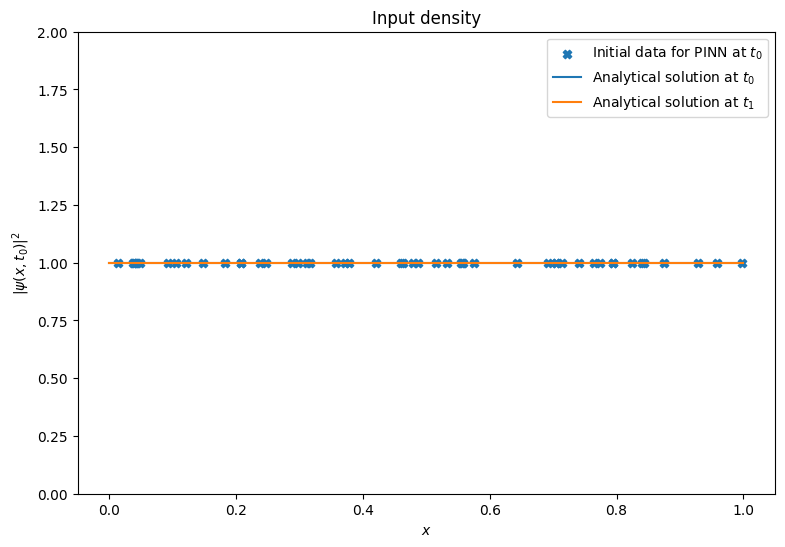

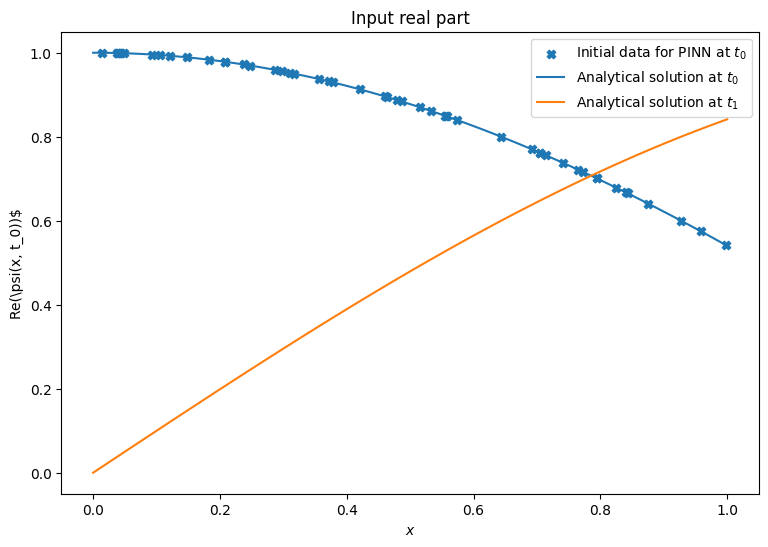

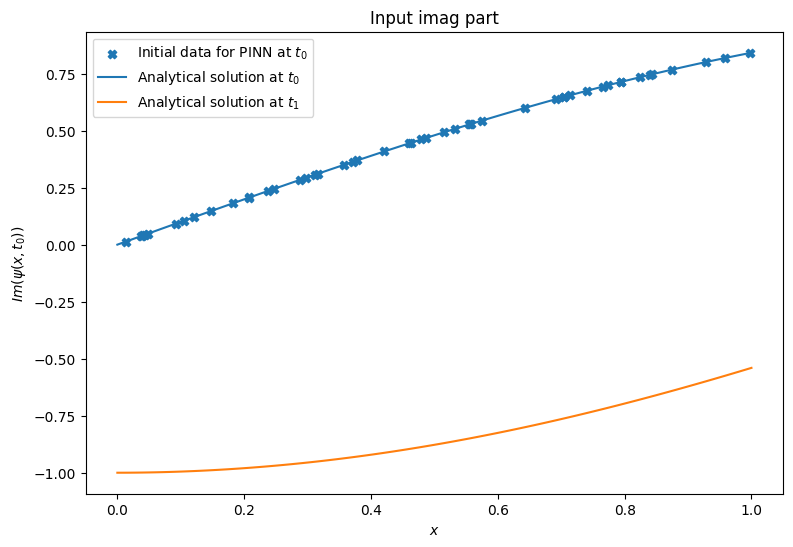

In [13]:
fig = plt.figure(figsize=(9,6))
plt.title('Input density')
plt.scatter(x_initial, get_density(psi_initial),  marker='X', label="Initial data for PINN at $t_0$")
plt.plot(x_linear, get_density(psi_0_linear), label=r"Analytical solution at $t_0$")
plt.plot(x_linear, get_density(psi_1_linear), label=r"Analytical solution at $t_1$")
plt.ylim(0, 2)
plt.xlabel('$x$')
plt.ylabel('$|\psi(x, t_0)|^2$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Input real part')
plt.scatter(x_initial, get_real(psi_initial),  marker='X', label="Initial data for PINN at $t_0$")
plt.plot(x_linear, get_real(psi_0_linear), label=r"Analytical solution at $t_0$")
plt.plot(x_linear, get_real(psi_1_linear), label=r"Analytical solution at $t_1$")
plt.xlabel('$x$')
plt.ylabel('Re(\psi(x, t_0))$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Input imag part')
plt.scatter(x_initial, get_imag(psi_initial),  marker='X', label="Initial data for PINN at $t_0$")
plt.plot(x_linear, get_imag(psi_0_linear), label=r"Analytical solution at $t_0$")
plt.plot(x_linear, get_imag(psi_1_linear), label=r"Analytical solution at $t_1$")
plt.xlabel('$x$')
plt.ylabel('$Im(\psi(x, t_0))$')#
plt.legend()
plt.show()
plt.close()

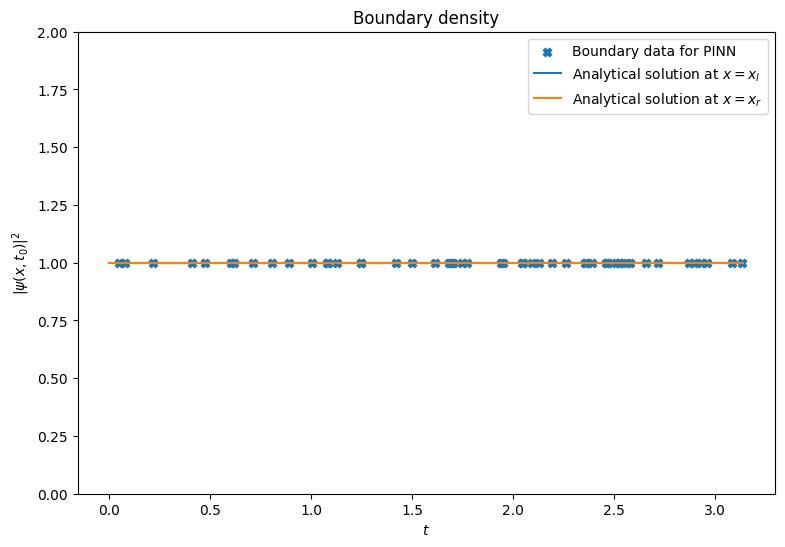

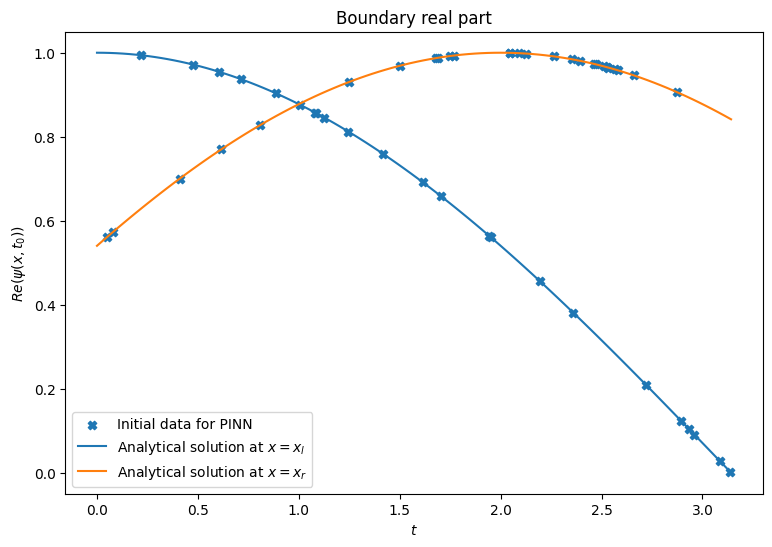

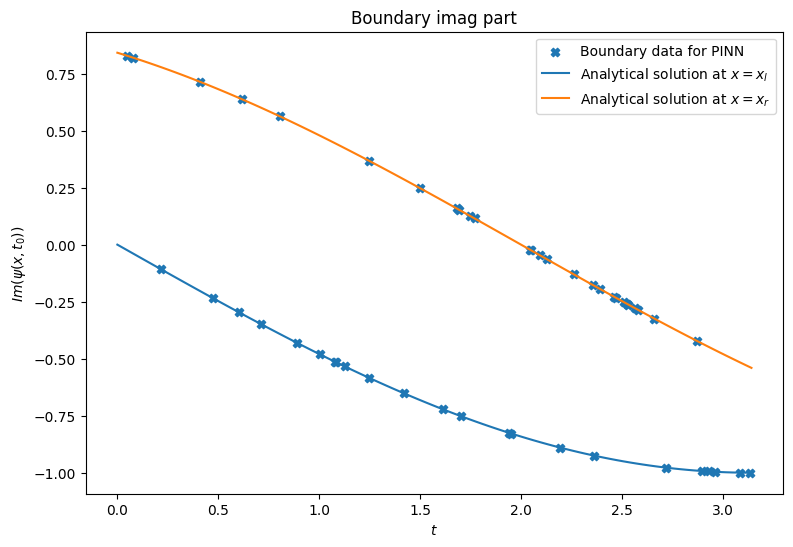

In [14]:
fig = plt.figure(figsize=(9,6))
plt.title('Boundary density')
plt.scatter(t_boundary, get_density(psi_boundary),  marker='X', label="Boundary data for PINN")
plt.plot(t_linear, get_density(psi_l_linear), label=r"Analytical solution at $x=x_l$")
plt.plot(t_linear, get_density(psi_r_linear), label=r"Analytical solution at $x=x_r$")
plt.ylim(0, 2)
plt.xlabel('$t$')
plt.ylabel('$|\psi(x, t_0)|^2$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Boundary real part')
plt.scatter(t_boundary, get_real(psi_boundary),  marker='X', label="Initial data for PINN")
plt.plot(t_linear, get_real(psi_l_linear), label=r"Analytical solution at $x=x_l$")
plt.plot(t_linear, get_real(psi_r_linear), label=r"Analytical solution at $x=x_r$")
plt.xlabel('$t$')
plt.ylabel('$Re(\psi(x, t_0))$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Boundary imag part')
plt.scatter(t_boundary, get_imag(psi_boundary),  marker='X', label="Boundary data for PINN")
plt.plot(t_linear, get_imag(psi_l_linear), label=r"Analytical solution at $x=x_l$")
plt.plot(t_linear, get_imag(psi_r_linear), label=r"Analytical solution at $x=x_r$")
plt.xlabel('$t$')
plt.ylabel('$Im(\psi(x, t_0))$')#
plt.legend()
plt.show()
plt.close()

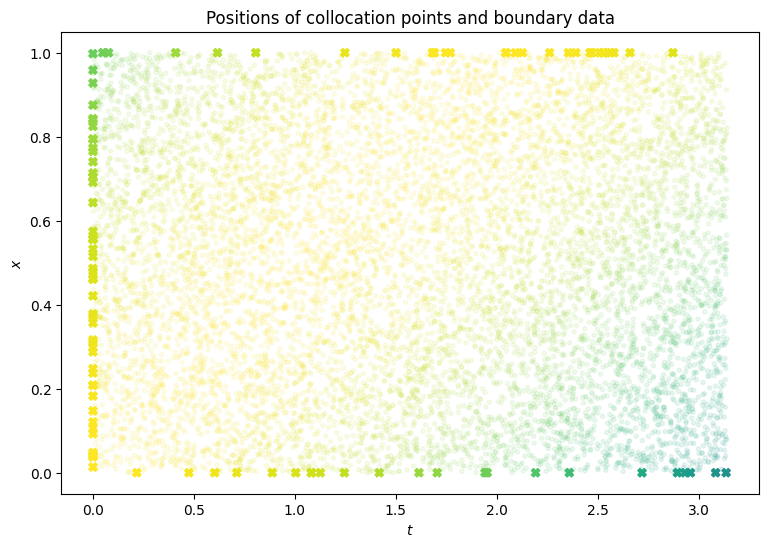

In [15]:
fig = plt.figure(figsize=(9,6))
plt.title('Positions of collocation points and boundary data')
plt.scatter(t_initial,     x_initial,     c=get_real(psi_initial),  marker='X', vmin=-1, vmax=1)
plt.scatter(t_boundary,    x_boundary,    c=get_real(psi_boundary), marker='X', vmin=-1, vmax=1)
plt.scatter(t_collocation, x_collocation, c=get_real(psi(x_collocation, t_collocation)), vmin=-1, vmax=1, marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.show()

## Create a neural network

Create simple fully connected feedforward model with $8$ hidden layers and $20$ neurons per layer.

In [16]:
# Lower bounds
lower_bounds = tf.stack([xl, t0], axis=0)
# Upper bound
upper_bounds = tf.stack([xr, t1], axis=0)

# Initialise fully-connected neural network
def init_model(num_hidden_layers=4, num_neurons_per_layer=20):
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(2)) # 2D input

    # normalise input to [-1, 1] in all dimensions
    scaling_layer = tf.keras.layers.Lambda(
        lambda x: 2.0*(x - lower_bounds)/(upper_bounds - lower_bounds) - 1.0
    )

    model.add(scaling_layer)

    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get("tanh"), kernel_initializer="glorot_normal"))

    model.add(tf.keras.layers.Dense(2)) # 2 outputs for real and imaginary part

    return model

# Check whether model interface works as expected
m = init_model()
m(xt_collocation)

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ 0.21555889, -0.26534158],
       [ 0.12540856, -0.1650639 ],
       [-0.40783116,  0.3707471 ],
       ...,
       [ 0.01941963, -0.03351644],
       [-0.27557528,  0.25146455],
       [ 0.14159241, -0.10288327]], dtype=float32)>


Compute gradients efficiently with gradient tape and return residual for given problem

In [17]:
def compute_residual(model, xt):
    with tf.GradientTape(persistent=True) as tape:
        # Separate x and t for GradientTape to watch variables separately
        x, t = xt[:,  0:1], xt[:, 1:2]
        tape.watch(x)
        tape.watch(t)

        # Stick x and t back together for model input
        xt_input = tf.concat([x, t], axis=1)
        psi = model(xt_input)

        # Split into real and imaginary parts
        re = psi[:, 0]
        im = psi[:, 1]

        # Compute gradient in tape environment in order to compute second derivatives
        re_x = tape.gradient(re, x)
        im_x = tape.gradient(im, x)

    re_t  = tape.gradient(re, t)
    im_t  = tape.gradient(im, t)
    re_xx = tape.gradient(re_x, x)
    im_xx = tape.gradient(im_x, x)

    del tape

    # R = i hbar psi_t + hbar^2/(2m) psi_xx - V psi should be minimised
    # -> Re(R) = -hbar Im(psi_t) + hbar^2/(2m) Re(psi_xx) - Re(V psi)
    # -> Im(I) =  hbar Re(psi_t) + hbar^2/(2m) Im(psi_xx) - Im(V psi)

    #residual_re = - hbar * im_t + 0.5 * hbar**2 / mass * re_xx
    #residual_im =   hbar * re_t + 0.5 * hbar**2 / mass * im_xx
    residual_re = re_t + 0.5 * im_xx
    residual_im = im_t - 0.5 * re_xx

    return tf.concat([residual_re, residual_im], axis=1)

# Check whether compute_residual works as expected
print(tf.reduce_mean(tf.square(compute_residual(init_model(), xt_collocation))))

tf.Tensor(0.112913266, shape=(), dtype=float32)


Compute loss by adding MSE of residual and for initial and boundary data

In [18]:
def compute_loss(model, xt_collocation, xt_initial, psi_initial, xt_boundary, psi_boundary):
    loss  = tf.reduce_mean(tf.square(compute_residual(model, xt_collocation))) # Enforce PDE dynamics
    loss += tf.reduce_mean(tf.square(model(xt_initial)  - psi_initial))        # Enforce initial conditions
    loss += tf.reduce_mean(tf.square(model(xt_boundary) - psi_boundary))       # Enforce boundary conditions
    return loss

Compute loss and run backpropagation

In [19]:
def compute_gradient(model, xt_collocation, xt_initial, psi_initial, xt_boundary, psi_boundary):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, xt_collocation, xt_initial, psi_initial, xt_boundary, psi_boundary)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g


Choose optimiser for model

In [22]:
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

Call model with collocation points C_r, points for initial and boundary conditions X_r and values for initial and boundaries conditions X_r, compute loss, run backpropagation and run optimiser with gradients.

In [ ]:
xt_initial.shape, psi_initial.shape

(TensorShape([50, 2]), TensorShape([50, 2]))

In [23]:
from time import time

@tf.function
def train_step():
    loss, grad_theta = compute_gradient(model, xt_collocation, xt_initial, psi_initial, xt_boundary, psi_boundary)

    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

N = 5000
hist = []

current_time = time()

for i in range(N+1):
    loss = train_step()
    hist.append(loss.numpy())

    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-current_time))


It 00000: loss = 8.71158481e-01
It 00050: loss = 1.47218257e-02
It 00100: loss = 2.66965246e-03
It 00150: loss = 8.76846199e-04
It 00200: loss = 3.86861444e-04
It 00250: loss = 2.12770334e-04
It 00300: loss = 5.26868447e-04
It 00350: loss = 1.19457953e-04
It 00400: loss = 8.75230762e-05
It 00450: loss = 6.93950715e-05
It 00500: loss = 1.47259940e-04
It 00550: loss = 9.02687461e-05
It 00600: loss = 5.01133472e-05
It 00650: loss = 9.27166082e-04
It 00700: loss = 5.88891817e-05
It 00750: loss = 4.11578294e-05
It 00800: loss = 3.52341340e-05
It 00850: loss = 3.09294082e-05
It 00900: loss = 2.75047496e-05
It 00950: loss = 4.32332745e-04
It 01000: loss = 2.95459377e-05
It 01050: loss = 2.73461974e-05
It 01100: loss = 2.68666772e-05
It 01150: loss = 2.64126575e-05
It 01200: loss = 2.59759199e-05
It 01250: loss = 2.55535233e-05
It 01300: loss = 2.51435558e-05
It 01350: loss = 2.47442149e-05
It 01400: loss = 2.43540162e-05
It 01450: loss = 2.39714936e-05
It 01500: loss = 2.35962470e-05
It 01550

## Check what model has learnt

### Check initial conditions

In [24]:
psi_initial_pred = model(xt_initial)
psi_initial_pred.shape

TensorShape([50, 2])

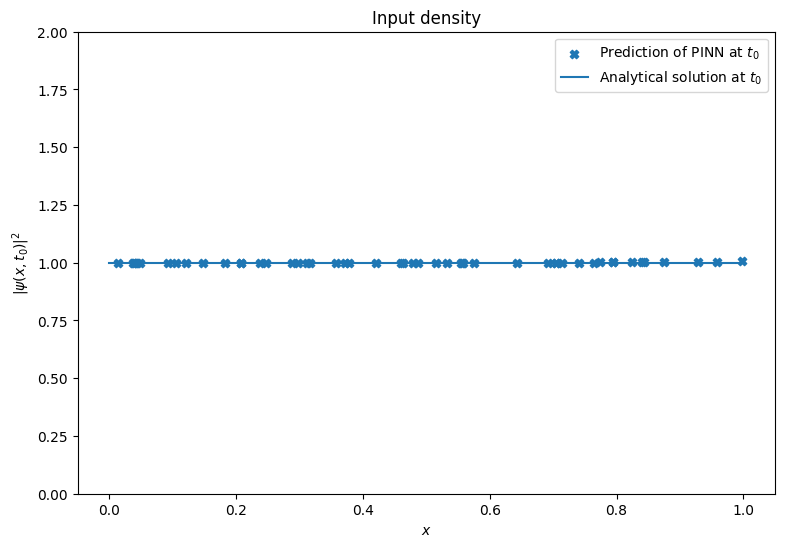

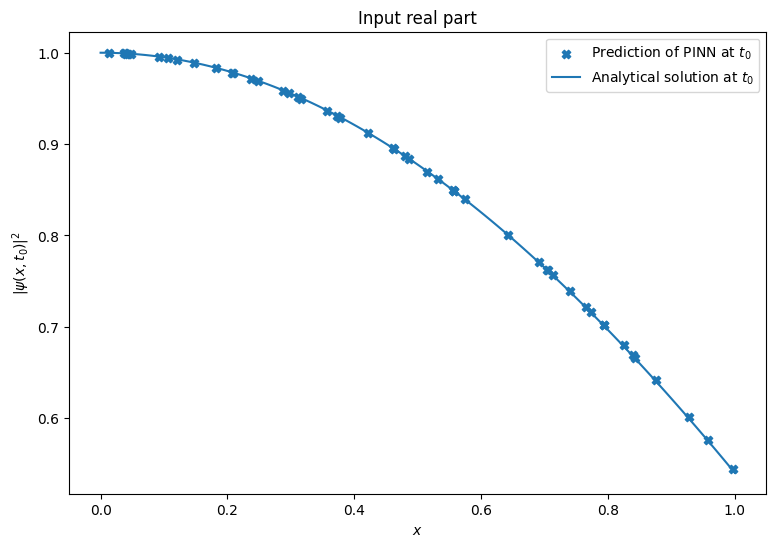

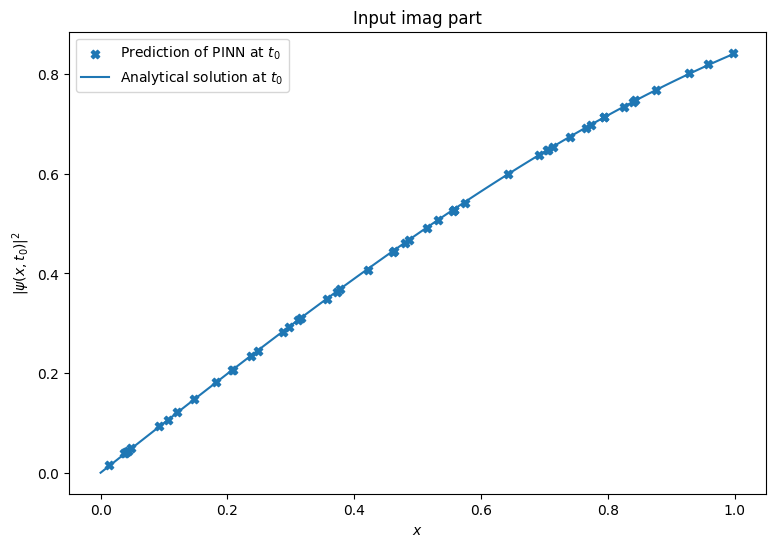

In [25]:

fig = plt.figure(figsize=(9,6))
plt.title('Input density')
plt.scatter(x_initial, get_density(psi_initial_pred),  marker='X', label="Prediction of PINN at $t_0$")
plt.plot(x_linear, get_density(psi_0_linear), label=r"Analytical solution at $t_0$")
plt.ylim(0, 2)
plt.xlabel('$x$')
plt.ylabel('$|\psi(x, t_0)|^2$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Input real part')
plt.scatter(x_initial, get_real(psi_initial_pred),  marker='X', label="Prediction of PINN at $t_0$")
plt.plot(x_linear, get_real(psi_0_linear), label=r"Analytical solution at $t_0$")
plt.xlabel('$x$')
plt.ylabel('$|\psi(x, t_0)|^2$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Input imag part')
plt.scatter(x_initial, get_imag(psi_initial_pred),  marker='X', label="Prediction of PINN at $t_0$")
plt.plot(x_linear, get_imag(psi_0_linear), label=r"Analytical solution at $t_0$")
plt.xlabel('$x$')
plt.ylabel('$|\psi(x, t_0)|^2$')#
plt.legend()
plt.show()
plt.close()

The model seems to have successfully learnt to describe the initial conditions.

### Check boundary conditions

In [26]:
psi_boundary_pred = model(xt_boundary)
psi_boundary_pred.shape

TensorShape([50, 2])

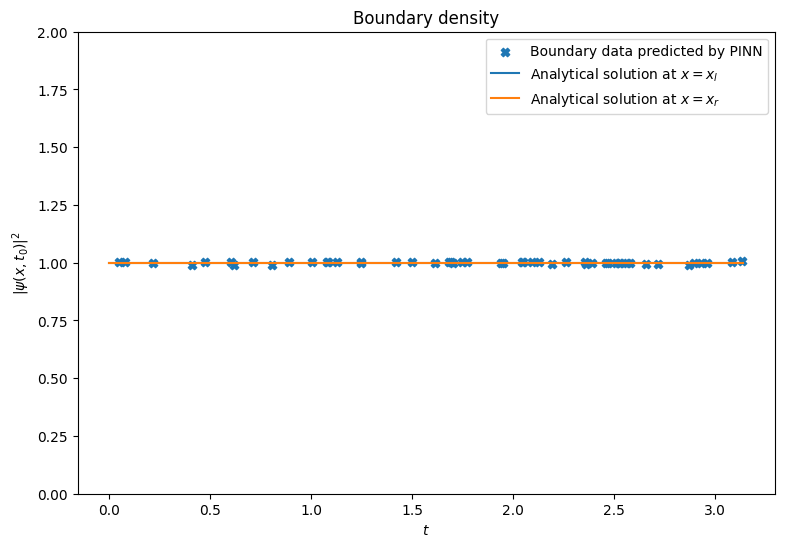

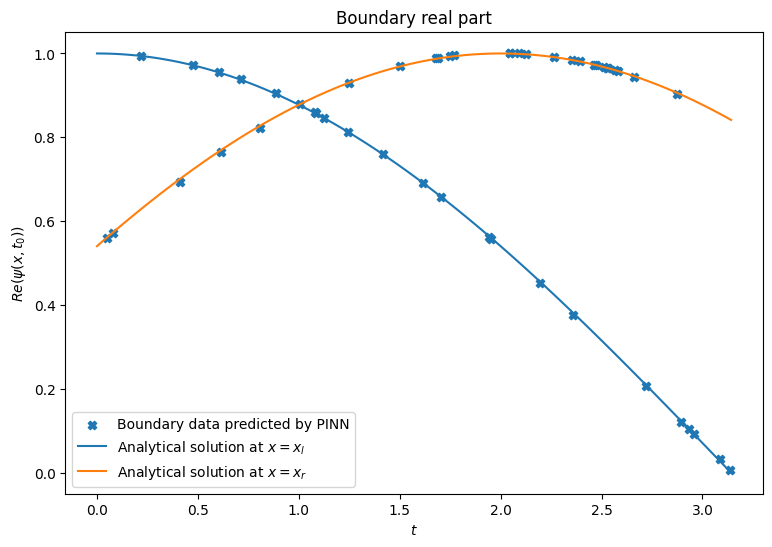

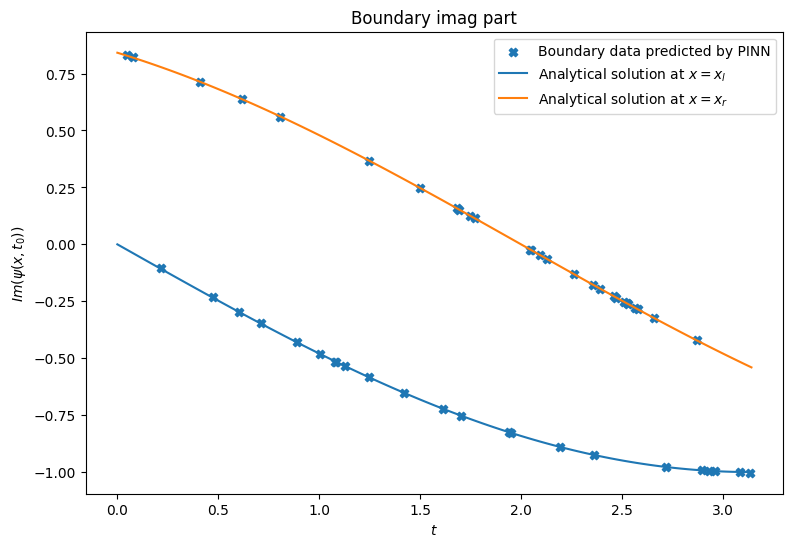

In [27]:
fig = plt.figure(figsize=(9,6))
plt.title('Boundary density')
plt.scatter(t_boundary, get_density(psi_boundary_pred),  marker='X', label="Boundary data predicted by PINN")
plt.plot(t_linear, get_density(psi_l_linear), label=r"Analytical solution at $x=x_l$")
plt.plot(t_linear, get_density(psi_r_linear), label=r"Analytical solution at $x=x_r$")
plt.ylim(0, 2)
plt.xlabel('$t$')
plt.ylabel('$|\psi(x, t_0)|^2$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Boundary real part')
plt.scatter(t_boundary, get_real(psi_boundary_pred),  marker='X', label="Boundary data predicted by PINN")
plt.plot(t_linear, get_real(psi_l_linear), label=r"Analytical solution at $x=x_l$")
plt.plot(t_linear, get_real(psi_r_linear), label=r"Analytical solution at $x=x_r$")
plt.xlabel('$t$')
plt.ylabel('$Re(\psi(x, t_0))$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Boundary imag part')
plt.scatter(t_boundary, get_imag(psi_boundary_pred),  marker='X', label="Boundary data predicted by PINN")
plt.plot(t_linear, get_imag(psi_l_linear), label=r"Analytical solution at $x=x_l$")
plt.plot(t_linear, get_imag(psi_r_linear), label=r"Analytical solution at $x=x_r$")
plt.xlabel('$t$')
plt.ylabel('$Im(\psi(x, t_0))$')#
plt.legend()
plt.show()
plt.close()

The model also seems to have successfully learnt to describe the boundary conditions.

### Check inside domain

In [28]:
psi_collocation_pred = model(xt_collocation)
psi_collocation_pred.shape

TensorShape([10000, 2])

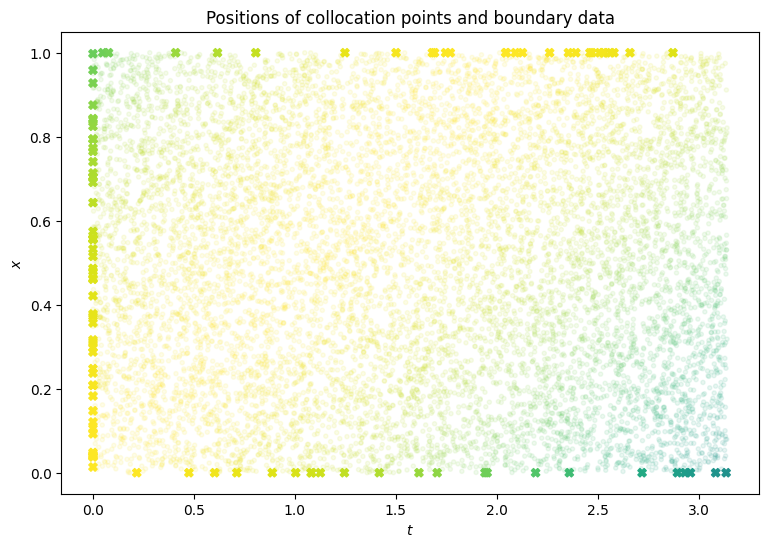

In [29]:
fig = plt.figure(figsize=(9,6))
plt.title('Positions of collocation points and boundary data')
plt.scatter(t_initial,     x_initial,     c=get_real(psi_initial),  marker='X', vmin=-1, vmax=1)
plt.scatter(t_boundary,    x_boundary,    c=get_real(psi_boundary), marker='X', vmin=-1, vmax=1)
plt.scatter(t_collocation, x_collocation, c=get_real(psi_collocation_pred), vmin=-1, vmax=1, marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.show()

This very much looks like the real part of a plane wave at the collocation points.

In [30]:
psi_collocation_ana = psi(x_collocation, t_collocation)
print("L1 error on collocation points: ", tf.reduce_mean(tf.abs(psi_collocation_ana - psi_collocation_pred)).numpy())

L1 error on collocation points:  0.0015465509


The error on the collocation points is also low.

In [31]:
n_test = 10000

# draw test points from uniform distribution
t_test  = tf.random.uniform((n_test,1), t0, t1, dtype=rtype)
x_test  = tf.random.uniform((n_test,1), xl, xr, dtype=rtype)
xt_test = tf.concat([x_test, t_test], axis=1)

psi_test_ana = psi(x_test, t_test)
psi_test_pred = model(xt_test)
print("L1 error on test points: ", tf.reduce_mean(tf.abs(psi_test_ana - psi_test_pred)).numpy())

L1 error on test points:  0.0015397215


The error on the test set is also low.

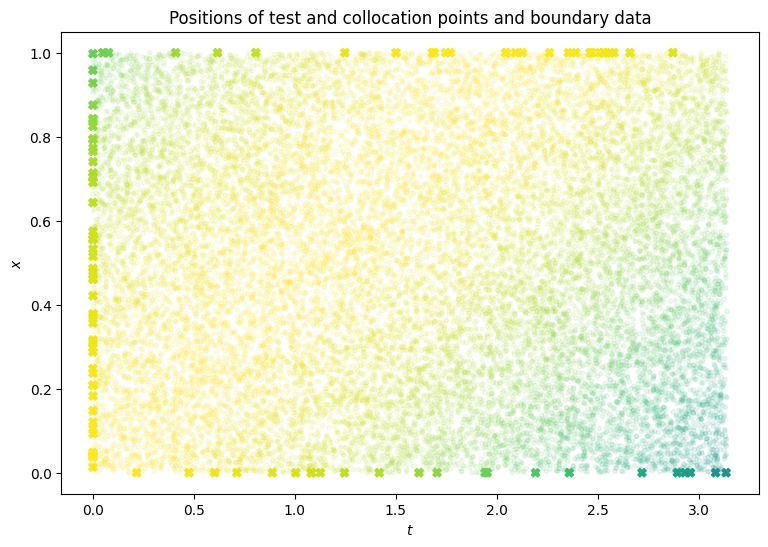

In [32]:
fig = plt.figure(figsize=(9,6))
t_total = tf.concat([t_collocation, t_test], axis=0)
x_total = tf.concat([x_collocation, x_test], axis=0)
xt_total = tf.concat([x_total, t_total], axis=1)
psi_total_ana  = psi(x_total, t_total)
psi_total_pred = model(xt_total)

plt.title('Positions of test and collocation points and boundary data')
plt.scatter(t_initial,     x_initial,     c=get_real(psi_initial),  marker='X', vmin=-1, vmax=1)
plt.scatter(t_boundary,    x_boundary,    c=get_real(psi_boundary), marker='X', vmin=-1, vmax=1)
plt.scatter(t_total, x_total, c=get_real(psi_total_pred), vmin=-1, vmax=1, marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.show()

In [33]:
# Set up meshgrid
xlin   = np.linspace(xl, xr, n_linear)
tlin   = np.linspace(t0, t1, n_linear)
xx, tt = np.meshgrid(xlin, tlin)
xxtt   = tf.cast(np.vstack([xx.flatten(),tt.flatten()]).T, rtype)

# Determine predictions of psi(t, x)
psi_pred = model(xxtt).numpy()
re_pred  = psi_pred[:,0]
im_pred  = psi_pred[:,1]
psi_ana  = psi(xxtt[:, 0:1], xxtt[:, 1:2]).numpy()
re_ana   = psi_ana[:,0]
im_ana   = psi_ana[:,1]

print("L1 error: ", np.mean(np.abs(re_ana - re_pred)))
print("Avg density of prediction", np.mean(re_pred**2 + im_pred**2))


L1 error:  0.0018777252
Avg density of prediction 0.99777323


Text(0.5, 0.92, 'Real part of solution of 1D Schrödinger equation')

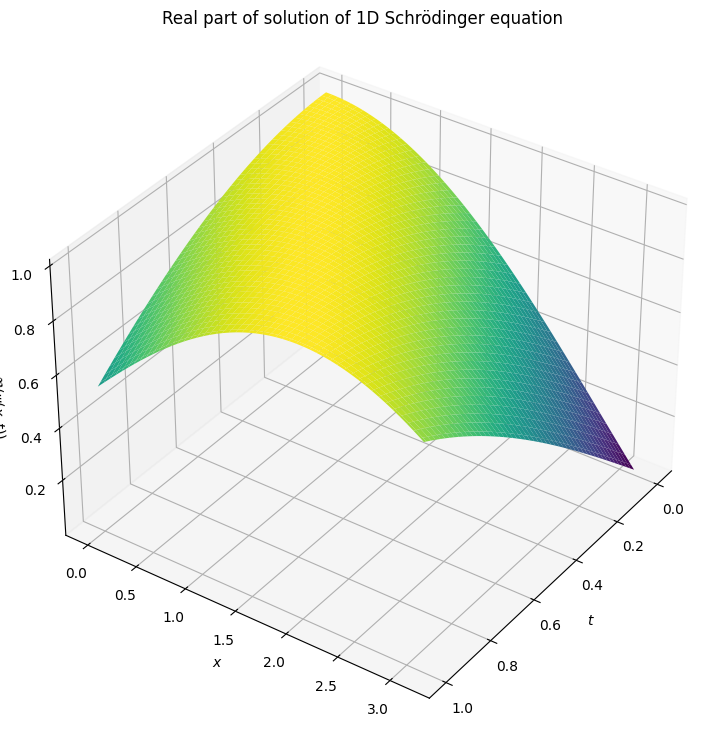

In [34]:
from mpl_toolkits.mplot3d import Axes3D

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, tt, re_pred.reshape(n_linear, n_linear), cmap='viridis')

ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$\Re(\psi(x, t))$')
ax.set_title('Real part of solution of 1D Schrödinger equation')

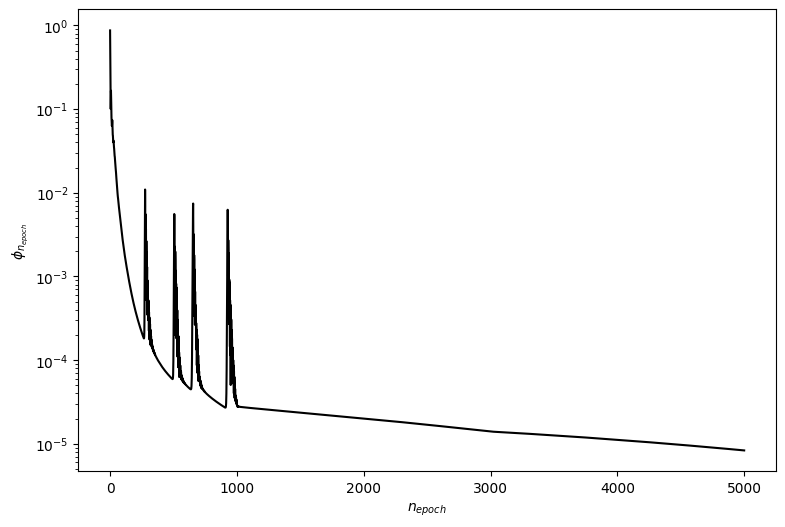

In [35]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');